To address the power shortage during nighttime in this solar power system, you can consider the following solutions:

1. Energy Storage (Batteries)
    
        Add Batteries to store excess solar energy generated during the day and use it at night.
        Size the battery system to meet the load during non-solar hours based on the daily energy deficit.
        Use tools like PyPSA to optimize battery sizing and charging/discharging schedules.


2. Hybrid System with Other Renewable Sources

        Combine solar power with other renewable energy sources that produce power at night, such as wind turbines. Wind generation often complements solar because wind patterns can be stronger at night.
        Add these sources to the system and simulate their combined performance in PyPSA.

3. Backup Generation with Dispatchable Power Sources

        Include a backup generator powered by natural gas, biogas, or diesel to cover the nighttime demand when solar and storage are insufficient.
        This option is less sustainable but ensures reliability.

4. Grid Connection for Import/Export

        Connect the system to the electric grid, allowing for:
        Exporting surplus solar energy during the day.
        Importing power during the night or cloudy periods.

5. Demand-Side Management (DSM)

        Encourage load shifting by rescheduling power-intensive activities to peak solar generation times.
        Introduce smart appliances and time-of-use pricing to align demand with solar availability.

6. Hydrogen Production and Fuel Cells

        Use excess daytime solar power to produce hydrogen through electrolysis.
        Store the hydrogen and use it in fuel cells to generate electricity at night.


Recommendation for Your Model:

        Start by integrating batteries into your PyPSA model to assess how much storage is needed to cover nighttime deficits.      Then, simulate the addition of other sources like wind or a backup generator to compare costs and reliability.

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.39s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00


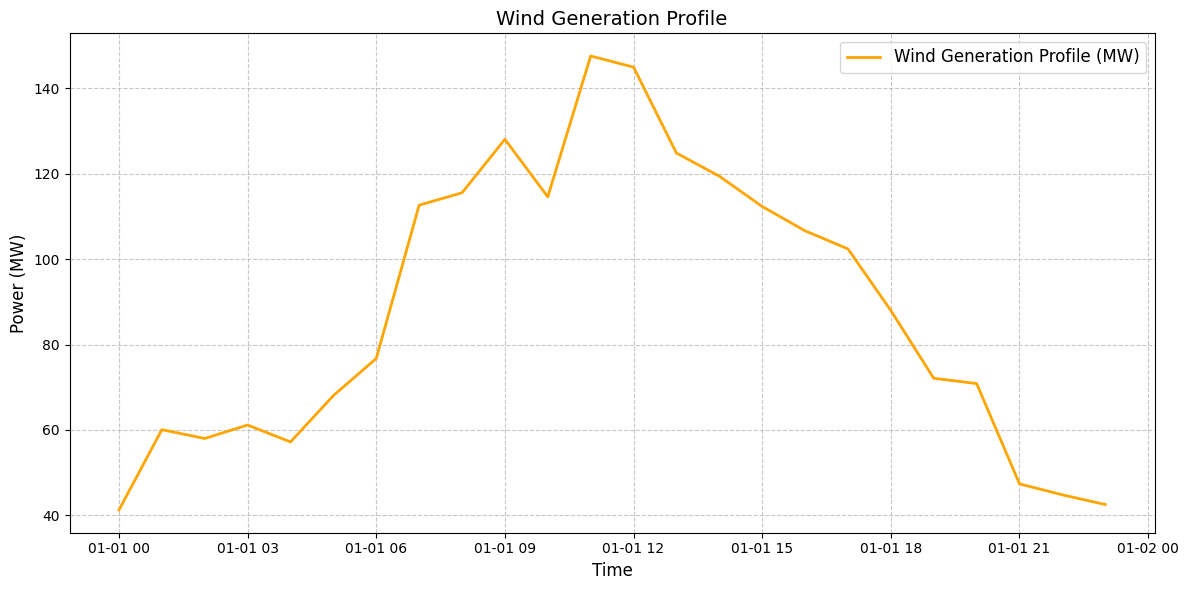

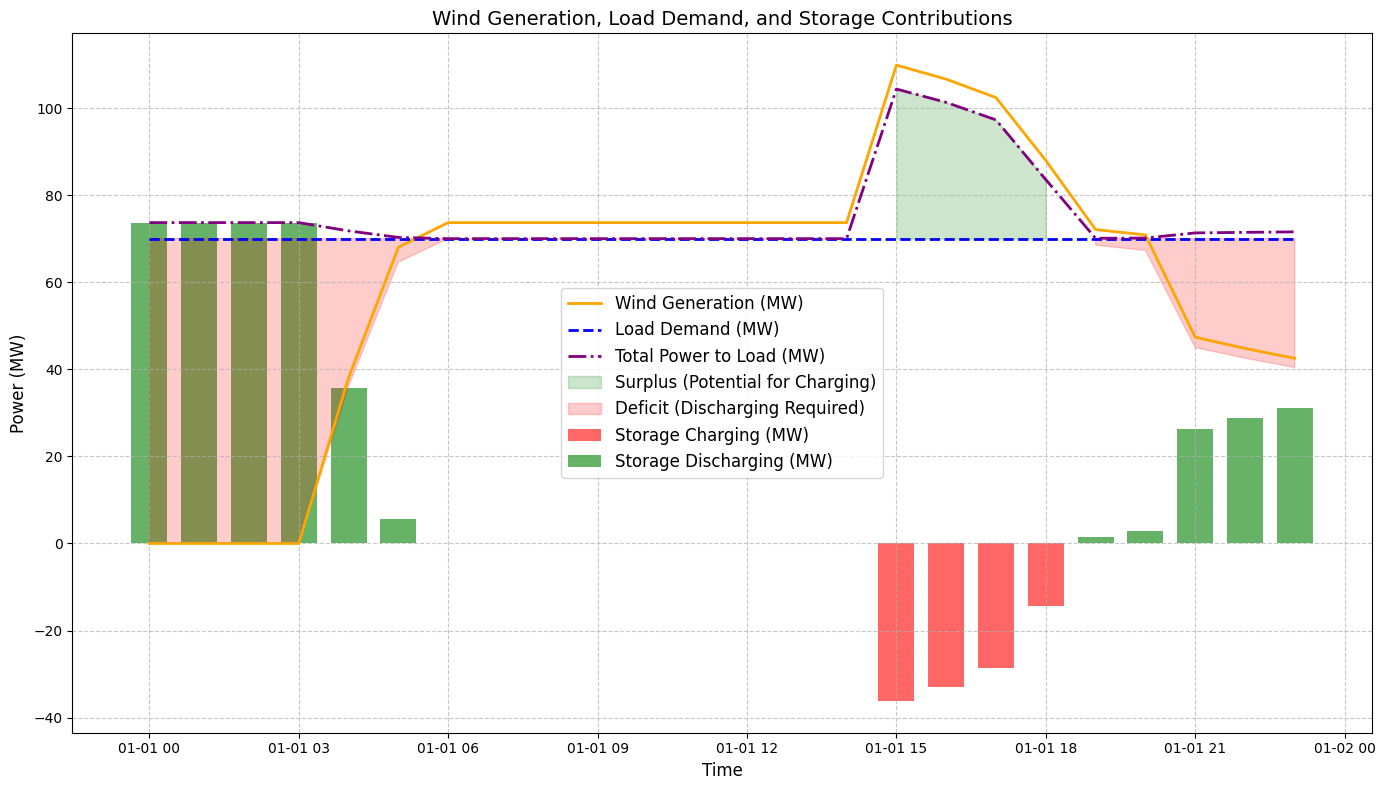

In [2]:
# Example 3 : Load - Wind Generator + Storage Unit
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create the network
network = pypsa.Network()

# Add Buses
network.add("Bus", "bus1", carrier="DC")  # DC side (wind generator to inverter)
network.add("Bus", "bus2", carrier="AC")  # AC side (inverter to load)

# Define time steps for the simulation
hours = pd.date_range("2023-01-01 00:00", "2023-01-01 23:00", freq="H")
network.set_snapshots(hours)

# Generate a realistic wind profile
np.random.seed(42)  # For reproducibility
wind_profile = pd.Series(0.5 + 0.3 * np.sin(2 * np.pi * (hours.hour - 6) / 24) + 0.2 * np.random.rand(len(hours)),
                         index=network.snapshots)
wind_profile = wind_profile.clip(lower=0, upper=1)  # Ensure values are within [0, 1]

# Add Wind Generator
p_nom_wind = 150  # Nominal power (MW)
network.add("Generator", "Wind Generator", bus="bus1", p_nom=p_nom_wind, p_max_pu=wind_profile, carrier="wind")

# Add Inverter (as a link)
inverter_efficiency = 0.95
network.add("Link", "Inverter", bus0="bus1", bus1="bus2", p_nom=p_nom_wind * 2, efficiency=inverter_efficiency, carrier="inverter")

# Define constant load demand
p_load = 70  # Load demand in MW
load_demand = pd.Series(p_load, index=network.snapshots)

# Add Load
network.add("Load", "Load", bus="bus2", p_set=load_demand)

# Add Storage Unit
network.add(
    "StorageUnit",
    "Battery Storage",
    bus="bus1",
    p_nom=200,
    max_hours=4,
    efficiency_store=0.9,
    efficiency_dispatch=0.9,
    state_of_charge_initial=400,
    carrier="battery"
)

# Solve the network using linear optimal power flow
network.lopf(network.snapshots)

# Extract results for storage and wind generation
storage_dispatch = network.storage_units_t.p["Battery Storage"]  # Charging (negative) and discharging (positive)
wind_generation = network.generators_t.p["Wind Generator"]  # Wind generation before inverter

# Total power delivered to the load (wind after inverter + battery discharge)
wind_to_load = wind_generation * inverter_efficiency  # Wind power after inverter losses
battery_to_load = storage_dispatch.clip(lower=0)  # Only discharging
total_power_to_load = wind_to_load + battery_to_load

# Separate charging and discharging for clarity
storage_charging = storage_dispatch.clip(upper=0)  # Negative values (charging)
storage_discharging = battery_to_load  # Positive values (discharging)

# Plot 1: Wind Generation Profile
plt.figure(figsize=(12, 6))
plt.plot(hours, wind_profile * p_nom_wind, label="Wind Generation Profile (MW)", color="orange", linewidth=2)
plt.title("Wind Generation Profile", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 2: Combined Plot
plt.figure(figsize=(14, 8))

# Plot Wind Generation and Load Demand
plt.plot(hours, wind_generation, label="Wind Generation (MW)", color="orange", linewidth=2)
plt.plot(hours, load_demand, label="Load Demand (MW)", color="blue", linestyle="--", linewidth=2)

# Overlay Storage Charging and Discharging
plt.bar(hours, storage_charging, label="Storage Charging (MW)", color="red", alpha=0.6, width=0.03)
plt.bar(hours, storage_discharging, label="Storage Discharging (MW)", color="green", alpha=0.6, width=0.03)

# Add the combined power to the load
plt.plot(hours, total_power_to_load, label="Total Power to Load (MW)", color="purple", linestyle="-.", linewidth=2)

# Add vertical shading for surplus and deficit regions
plt.fill_between(
    hours,
    wind_to_load,
    load_demand,
    where=(wind_to_load > load_demand),
    color="green",
    alpha=0.2,
    label="Surplus (Potential for Charging)"
)
plt.fill_between(
    hours,
    wind_to_load,
    load_demand,
    where=(wind_to_load < load_demand),
    color="red",
    alpha=0.2,
    label="Deficit (Discharging Required)"
)

# Labels, Legend, and Grid
plt.title("Wind Generation, Load Demand, and Storage Contributions", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the combined plot
plt.show()


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.5s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00


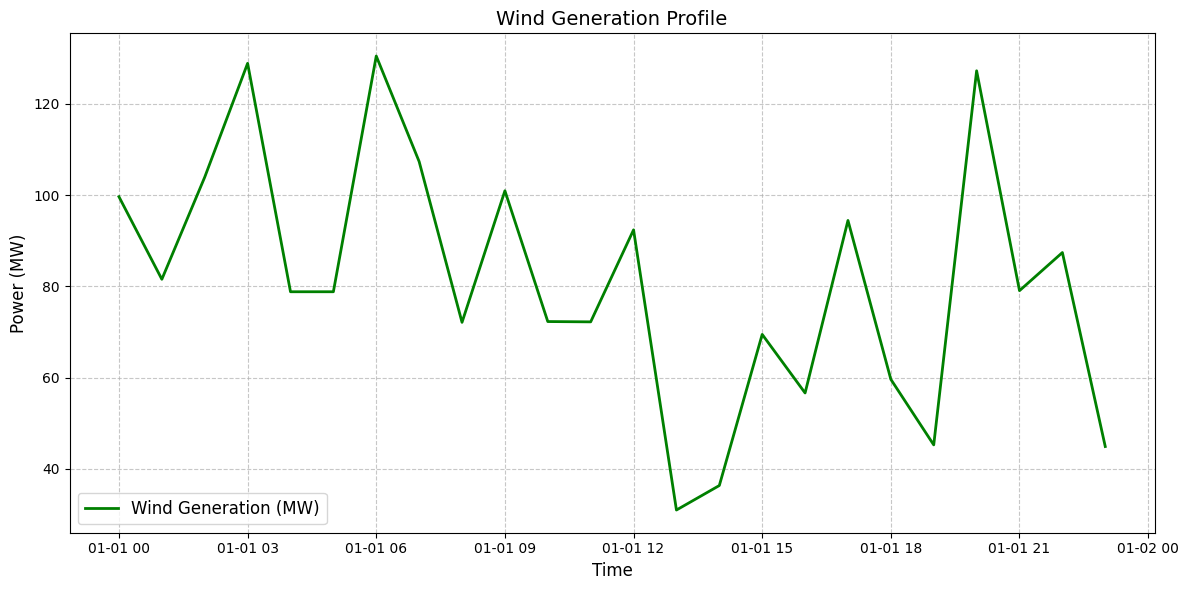

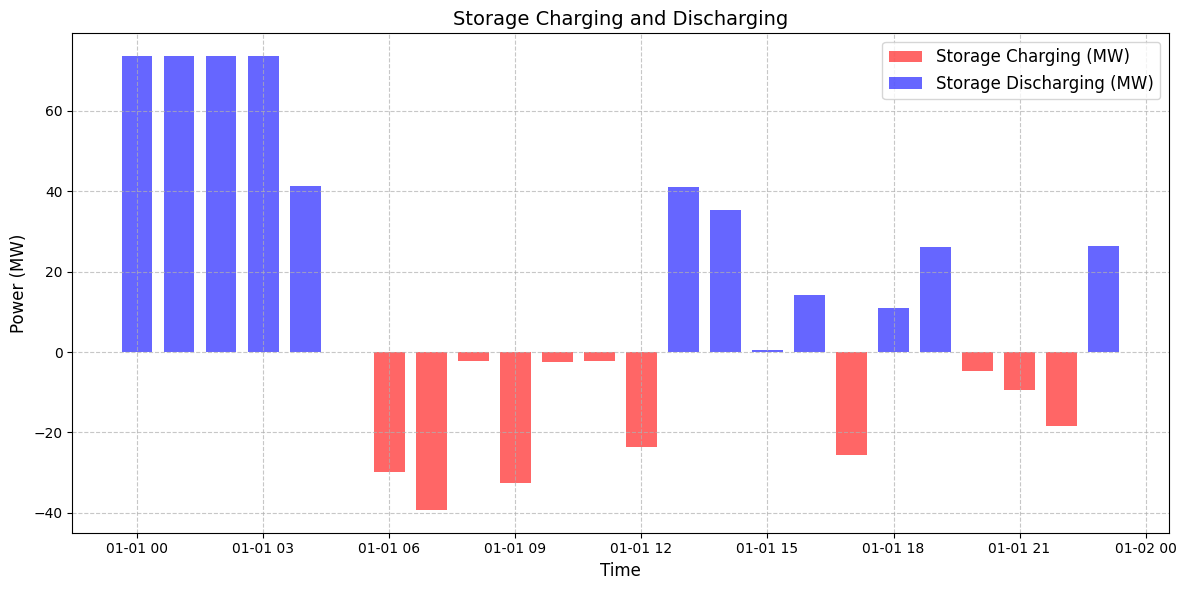

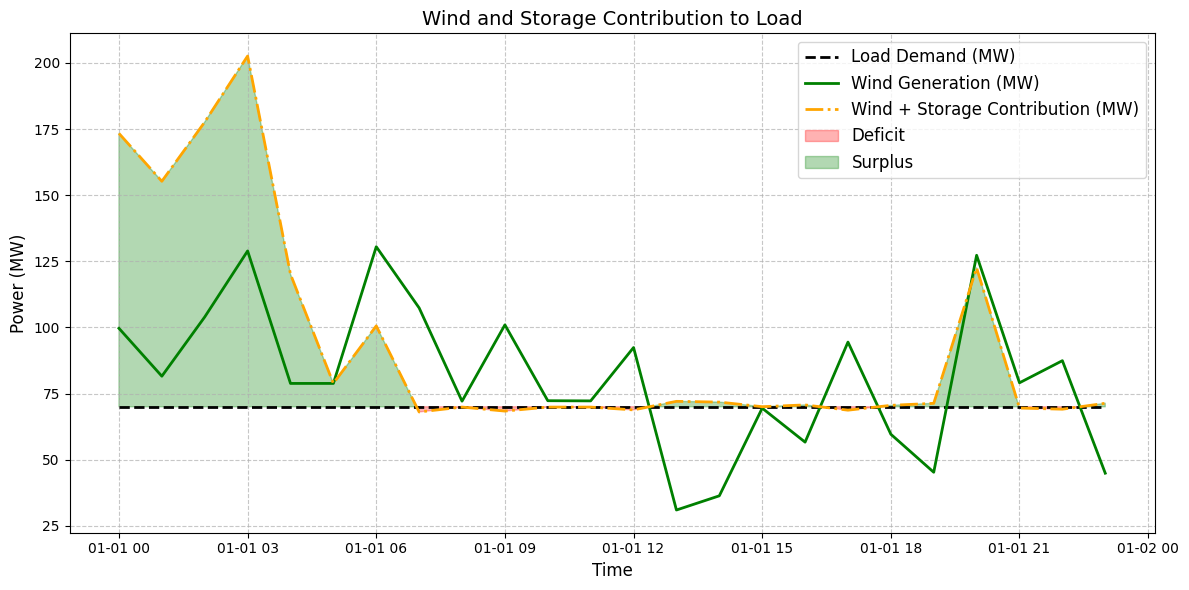

In [3]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create the network
network = pypsa.Network()

# Add Buses
network.add("Bus", "bus1", carrier="DC")  # DC side (wind generator to inverter)
network.add("Bus", "bus2", carrier="AC")  # AC side (inverter to load)

# Define time steps for the simulation
hours = pd.date_range("2023-01-01 00:00", "2023-01-01 23:00", freq="H")
network.set_snapshots(hours)

# Generate a realistic wind profile
np.random.seed(42)  # For reproducibility
base_wind_speed = 0.6  # Average capacity factor (60%)
variability = 0.2  # Wind speed variability
wind_profile = pd.Series(
    base_wind_speed + variability * np.random.randn(len(hours)),
    index=hours
).clip(lower=0, upper=1)  # Ensure the values are between 0 and 1

# Add Wind Generator
p_nom_wind = 150  # Nominal power (MW)
network.add("Generator", "Wind Generator", bus="bus1", p_nom=p_nom_wind, p_max_pu=wind_profile, carrier="wind")

# Add Inverter (as a link)
inverter_efficiency = 0.95
network.add("Link", "Inverter", bus0="bus1", bus1="bus2", p_nom=p_nom_wind * 2, efficiency=inverter_efficiency, carrier="inverter")

# Define constant load demand
p_load = 70  # Load demand in MW
load_demand = pd.Series(p_load, index=network.snapshots)  # Constant across all snapshots

# Add Load
network.add("Load", "Load", bus="bus2", p_set=load_demand)

# Add Storage Unit
network.add(
    "StorageUnit",
    "Battery Storage",
    bus="bus1",
    p_nom=200,  # Maximum charging/discharging power (MW)
    max_hours=4,  # Max energy storage in hours
    efficiency_store=0.9,  # Charging efficiency
    efficiency_dispatch=0.9,  # Discharging efficiency
    state_of_charge_initial=400,  # Initial state of charge (MWh)
    carrier="battery",
)

# Solve the network using linear optimal power flow
network.lopf(network.snapshots)

# Extract results
wind_generation = wind_profile * p_nom_wind * inverter_efficiency  # Wind generation after inverter
storage_dispatch = network.storage_units_t.p["Battery Storage"]  # Charging (negative) and discharging (positive)
storage_charging = storage_dispatch.clip(upper=0)  # Charging (negative values)
storage_discharging = storage_dispatch.clip(lower=0)  # Discharging (positive values)
total_to_load = wind_generation + storage_dispatch  # Combined wind and storage contribution

# Plot 1: Wind Generation Profile
plt.figure(figsize=(12, 6))
plt.plot(hours, wind_generation, label="Wind Generation (MW)", color="green", linewidth=2)
plt.title("Wind Generation Profile", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 2: Storage Activity
plt.figure(figsize=(12, 6))
plt.bar(hours, storage_charging, label="Storage Charging (MW)", color="red", alpha=0.6, width=0.03)
plt.bar(hours, storage_discharging, label="Storage Discharging (MW)", color="blue", alpha=0.6, width=0.03)
plt.title("Storage Charging and Discharging", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 3: Total Contribution to Load
plt.figure(figsize=(12, 6))
plt.plot(hours, load_demand, label="Load Demand (MW)", color="black", linestyle="--", linewidth=2)
plt.plot(hours, wind_generation, label="Wind Generation (MW)", color="green", linewidth=2)
plt.plot(hours, total_to_load, label="Wind + Storage Contribution (MW)", color="orange", linestyle="-.", linewidth=2)
plt.fill_between(hours, total_to_load, load_demand, where=(total_to_load < load_demand), interpolate=True, color="red", alpha=0.3, label="Deficit")
plt.fill_between(hours, total_to_load, load_demand, where=(total_to_load >= load_demand), interpolate=True, color="green", alpha=0.3, label="Surplus")
plt.title("Wind and Storage Contribution to Load", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.4s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00


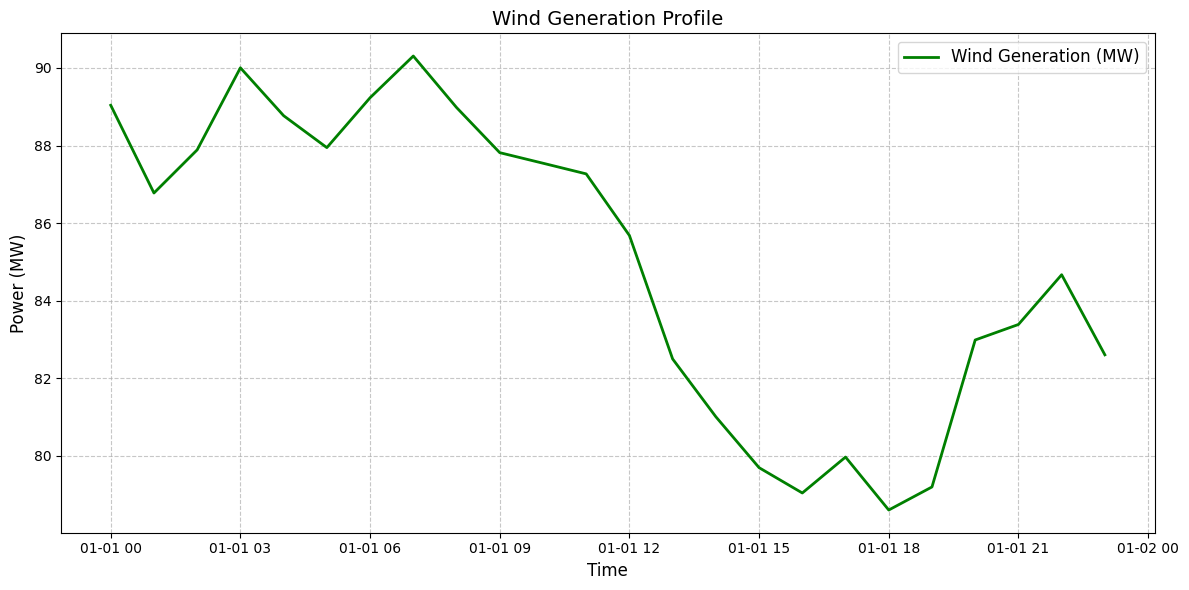

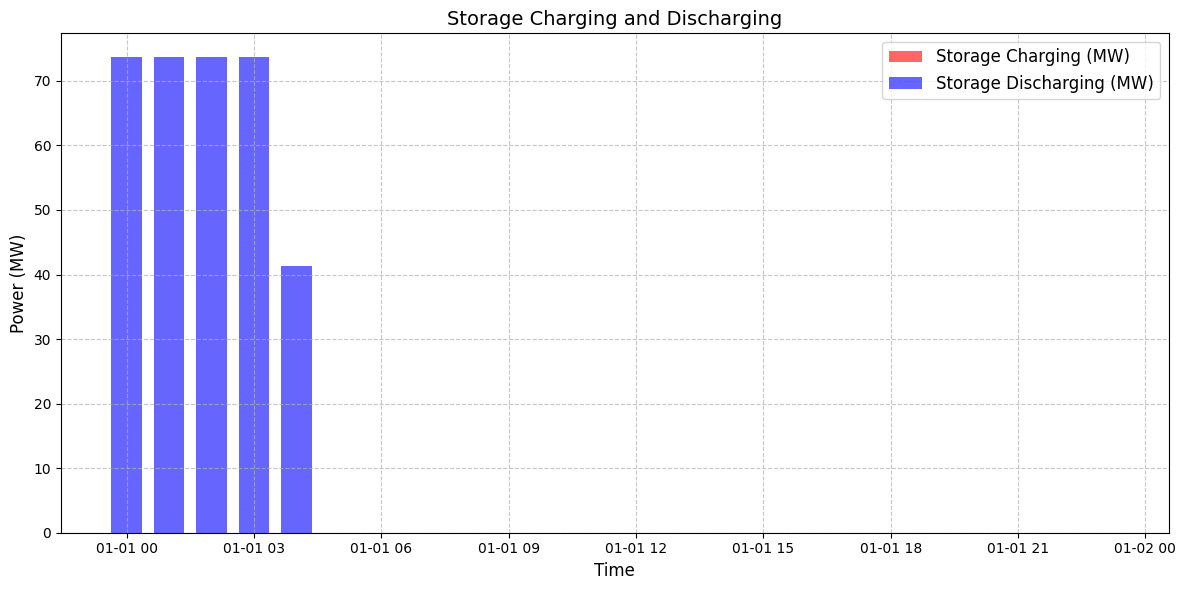

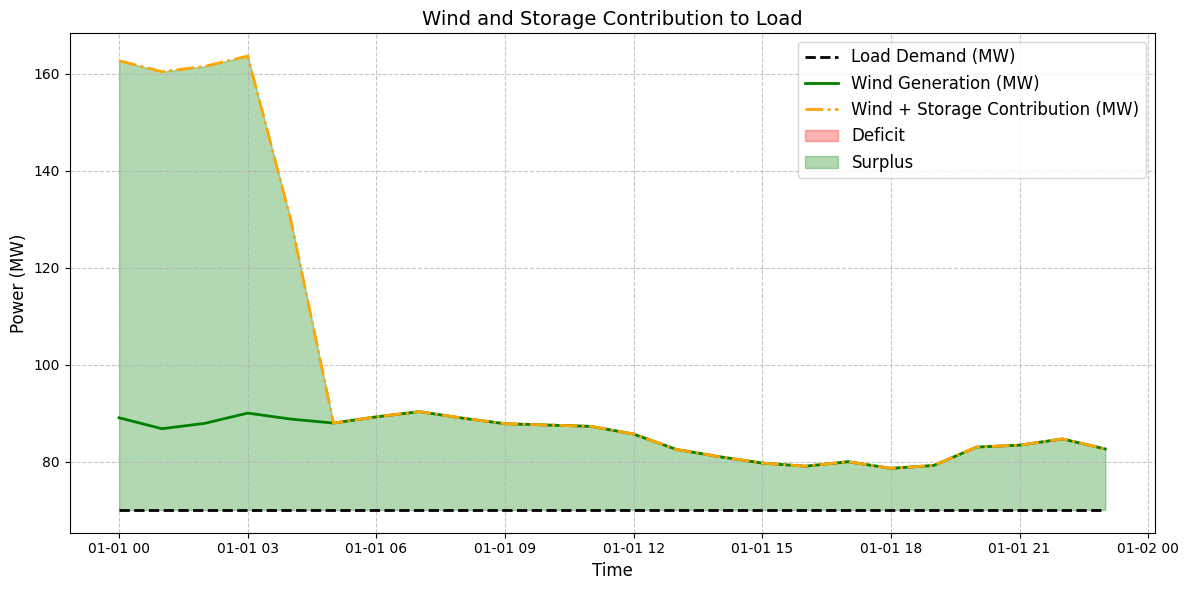

In [5]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create the network
network = pypsa.Network()

# Add Buses
network.add("Bus", "bus1", carrier="DC")  # DC side (wind generator to inverter)
network.add("Bus", "bus2", carrier="AC")  # AC side (inverter to load)

# Define time steps for the simulation
hours = pd.date_range("2023-01-01 00:00", "2023-01-01 23:00", freq="H")
network.set_snapshots(hours)

# Generate a smoother wind profile using larger variability
np.random.seed(42)  # For reproducibility
base_wind_speed = 0.6  # Average capacity factor (60%)
variability = 0.05  # Reduced variability for even smoother profile
wind_profile = pd.Series(
    base_wind_speed + variability * np.random.randn(len(hours)),
    index=hours
).clip(lower=0, upper=1)  # Ensure the values are between 0 and 1

# Apply a stronger moving average (window size = 6) for smoother profile
wind_profile_smooth = wind_profile.rolling(window=6, min_periods=1).mean()

# Add Wind Generator
p_nom_wind = 150  # Nominal power (MW)
network.add("Generator", "Wind Generator", bus="bus1", p_nom=p_nom_wind, p_max_pu=wind_profile_smooth, carrier="wind")

# Add Inverter (as a link)
inverter_efficiency = 0.95
network.add("Link", "Inverter", bus0="bus1", bus1="bus2", p_nom=p_nom_wind * 2, efficiency=inverter_efficiency, carrier="inverter")

# Define constant load demand
p_load = 70  # Load demand in MW
load_demand = pd.Series(p_load, index=network.snapshots)  # Constant across all snapshots

# Add Load
network.add("Load", "Load", bus="bus2", p_set=load_demand)

# Add Storage Unit
network.add(
    "StorageUnit",
    "Battery Storage",
    bus="bus1",
    p_nom=200,  # Maximum charging/discharging power (MW)
    max_hours=4,  # Max energy storage in hours
    efficiency_store=0.9,  # Charging efficiency
    efficiency_dispatch=0.9,  # Discharging efficiency
    state_of_charge_initial=400,  # Initial state of charge (MWh)
    carrier="battery",
)

# Solve the network using linear optimal power flow
network.lopf(network.snapshots)

# Extract results
wind_generation = wind_profile_smooth * p_nom_wind * inverter_efficiency  # Wind generation after inverter
storage_dispatch = network.storage_units_t.p["Battery Storage"]  # Charging (negative) and discharging (positive)
storage_charging = storage_dispatch.clip(upper=0)  # Charging (negative values)
storage_discharging = storage_dispatch.clip(lower=0)  # Discharging (positive values)
total_to_load = wind_generation + storage_dispatch  # Combined wind and storage contribution

# Plot 1: Wind Generation Profile
plt.figure(figsize=(12, 6))
plt.plot(hours, wind_generation, label="Wind Generation (MW)", color="green", linewidth=2)
plt.title("Wind Generation Profile", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 2: Storage Activity
plt.figure(figsize=(12, 6))
plt.bar(hours, storage_charging, label="Storage Charging (MW)", color="red", alpha=0.6, width=0.03)
plt.bar(hours, storage_discharging, label="Storage Discharging (MW)", color="blue", alpha=0.6, width=0.03)
plt.title("Storage Charging and Discharging", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 3: Total Contribution to Load
plt.figure(figsize=(12, 6))
plt.plot(hours, load_demand, label="Load Demand (MW)", color="black", linestyle="--", linewidth=2)
plt.plot(hours, wind_generation, label="Wind Generation (MW)", color="green", linewidth=2)
plt.plot(hours, total_to_load, label="Wind + Storage Contribution (MW)", color="orange", linestyle="-.", linewidth=2)
plt.fill_between(hours, total_to_load, load_demand, where=(total_to_load < load_demand), interpolate=True, color="red", alpha=0.3, label="Deficit")
plt.fill_between(hours, total_to_load, load_demand, where=(total_to_load >= load_demand), interpolate=True, color="green", alpha=0.3, label="Surplus")
plt.title("Wind and Storage Contribution to Load", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
